In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
from captum.attr import IntegratedGradients, NoiseTunnel
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=36,
        output_chunk_length=24,
        hidden_dim=96,
        n_rnn_layers=3,
        n_epochs=100,
        batch_size=80,
        dropout=0.1,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0020101615632169517, "weight_decay": 4.080126913056516e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=24,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
                'WMAPE': wmape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 6.420
Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 6.384
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.379
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.374
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 6.355
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.355. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    46.360759    6.808874    5.009194 -0.001225   
Precipitation_accumulated   59492.949875  243.911767  133.497751 -0.423952   
Humidity                     1360.729931   36.888073   30.962255 -3.497064   
Wind_Speed_kmh                  1.142979    1.069102    0.858420 -1.379518   
Soil_Moisture              810881.028693  900.489327  783.275397  0.340906   
Soil_Temperature               43.079981    6.563534    5.010302  0.245286   
Wind_Dir_Sin                    1.180924    1.086703    0.897639 -2.285767   
Wind_Dir_Cos                    0.538098    0.733552    0.613427  0.047885   

                                SMAPE       WMAPE  
Temperature                 30.854724   30.268142  
Precipitation_accumulated   83.499968   97.755710  
Humidity                    51.538127   40.698917  

Metric val_loss improved. New best score: 0.222
Metric val_loss improved by 0.135 >= min_delta = 0.001. New best score: 0.087
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.072
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.066
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.063
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.063. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    18.733428    4.328213    3.749983   
Precipitation_accumulated      29.623029    5.442704    4.360739   
Humidity                       66.091468    8.129666    6.841052   
Wind_Speed_kmh                  0.082013    0.286379    0.251707   
Soil_Moisture              113599.530107  337.045294  280.269448   
Soil_Temperature               23.730153    4.871361    4.234604   
Wind_Dir_Sin                    0.113604    0.337052    0.259189   
Wind_Dir_Cos                    0.110559    0.332504    0.237622   

                                     R2       SMAPE         WMAPE  
Temperature               -1.327806e+00   25.264037  2.411398e+01  
Precipitation_accumulated -6.039627e+03    0.946402  9.518784e-01  
Humidity                  -2.198590e+00    7.921736  7.958505e+00  
Wind_Speed_kmh           

Metric val_loss improved. New best score: 0.082
Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 0.044
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.042
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.032
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.019
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.019. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                    0.582176    0.763004    0.586580  -0.037092   
Precipitation_accumulated      3.129431    1.769020    1.602076 -76.700589   
Humidity                      10.622444    3.259209    2.716993  -0.110268   
Wind_Speed_kmh                 0.005048    0.071049    0.065490       -inf   
Soil_Moisture              90068.446652  300.114056  267.700975  -1.574563   
Soil_Temperature               0.254413    0.504394    0.399475  -0.294478   
Wind_Dir_Sin                   0.000601    0.024506    0.020590       -inf   
Wind_Dir_Cos                   0.000214    0.014622    0.013653       -inf   

                                SMAPE     WMAPE  
Temperature                  6.209731  6.320690  
Precipitation_accumulated    0.350179  0.349473  
Humidity                     2.981028  2.983028  
Wind_Sp

Metric val_loss improved. New best score: 0.117
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.113
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.110
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.104
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.102
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.100
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.096
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.095
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.094
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.092
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.090
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.088
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.088. Signaling

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                     7.617138    2.759916    2.327605   
Precipitation_accumulated   53944.750832  232.260093  130.365356   
Humidity                      267.078512   16.342537   15.006829   
Wind_Speed_kmh                  0.598692    0.773752    0.460513   
Soil_Moisture              424956.498354  651.886875  374.563647   
Soil_Temperature               12.545034    3.541897    2.911504   
Wind_Dir_Sin                    0.271018    0.520594    0.348296   
Wind_Dir_Cos                    0.360675    0.600562    0.346582   

                                     R2       SMAPE      WMAPE  
Temperature                   -0.435243   41.962214  41.280687  
Precipitation_accumulated -45902.952102   51.736481  28.337187  
Humidity                      -2.174972   17.586744  17.821815  
Wind_Speed_kmh                 0.3400

Metric val_loss improved. New best score: 0.198
Metric val_loss improved by 0.057 >= min_delta = 0.001. New best score: 0.141
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.139
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.131
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.125
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.123
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.123. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                   12.727465    3.567557    2.800852   0.545670   
Precipitation_accumulated     47.174098    6.868340    6.149617 -28.998910   
Humidity                      98.635246    9.931528    7.845273   0.368529   
Wind_Speed_kmh                 1.566424    1.251569    0.971240  -0.227880   
Soil_Moisture              88128.574527  296.864573  272.775851 -13.160307   
Soil_Temperature               8.752228    2.958417    2.450584   0.339179   
Wind_Dir_Sin                   0.618354    0.786355    0.664112  -0.123451   
Wind_Dir_Cos                   0.417399    0.646064    0.566869  -0.183401   

                                SMAPE       WMAPE  
Temperature                 33.169735   27.950639  
Precipitation_accumulated    1.332089    1.322006  
Humidity                     9.431495    9.125129  


Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.040
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.030
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. Ne

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    4.752625    2.180052    1.697513  0.905099   
Precipitation_accumulated      0.174952    0.418273    0.294117  0.721459   
Humidity                      28.955552    5.381036    3.967055  0.907583   
Wind_Speed_kmh                 0.288383    0.537013    0.411398  0.317290   
Soil_Moisture              37358.852127  193.284381  121.140288  0.939554   
Soil_Temperature               9.152837    3.025366    2.339787  0.873888   
Wind_Dir_Sin                   0.254916    0.504892    0.392355  0.201527   
Wind_Dir_Cos                   0.314540    0.560839    0.421715  0.184846   

                               SMAPE  
Temperature                10.916335  
Precipitation_accumulated   9.083919  
Humidity                    6.513420  
Wind_Speed_kmh             51.315910  
Soil_Moisture        

Metric val_loss improved. New best score: 6.222
Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 6.186
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.184
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.178
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 6.167
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.161
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.159
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.156
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.148
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.145
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.137
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.136
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 6.128
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE          R2  \
Temperature                7.992424e+01     8.940036     7.266702   -1.298805   
Precipitation_accumulated  1.335065e+05   365.385358   311.490070   -2.343205   
Humidity                   4.801465e+02    21.912246    18.438468   -2.814734   
Wind_Speed_kmh             6.284671e+01     7.927592     6.853446 -190.368188   
Soil_Moisture              7.704218e+06  2775.647386  2371.351451   -4.116807   
Soil_Temperature           3.134313e+01     5.598494     4.563495    0.125786   
Wind_Dir_Sin               3.707535e+00     1.925496     1.706030  -14.527084   
Wind_Dir_Cos               4.505036e-01     0.671196     0.591663    0.310421   

                                SMAPE  
Temperature                 53.471422  
Precipitation_accumulated  134.840031  
Humidity                    19.915460  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    1.866238    1.366103    1.091031  6.675618e-01   
Precipitation_accumulated    391.324256   19.781917   18.645452 -3.270694e+06   
Humidity                       7.465043    2.732223    2.216044  5.648532e-01   
Wind_Speed_kmh                 0.006279    0.079241    0.063408          -inf   
Soil_Moisture              49337.465516  222.120385  192.864466 -3.601227e+01   
Soil_Temperature               3.213707    1.792681    1.522270  4.946519e-01   
Wind_Dir_Sin                   0.019019    0.137909    0.124255          -inf   
Wind_Dir_Cos                   0.008025    0.089582    0.074510          -inf   

                                SMAPE  
Temperature                  7.523339  
Precipitation_accumulated    3.978792  
Humidity                     2.546081  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.363596    0.602989    0.444561     0.360243   
Precipitation_accumulated     70.598734    8.402305    7.733632 -2138.652954   
Humidity                       6.095052    2.468816    2.035408     0.372354   
Wind_Speed_kmh                 0.079839    0.282558    0.265523         -inf   
Soil_Moisture              29501.097236  171.758835  152.034351     0.159725   
Soil_Temperature               0.520785    0.721654    0.542822    -1.268143   
Wind_Dir_Sin                   0.004069    0.063789    0.051804         -inf   
Wind_Dir_Cos                   0.004771    0.069073    0.054884         -inf   

                                SMAPE  
Temperature                  4.795408  
Precipitation_accumulated    1.704103  
Humidity                     2.251149  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.008
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarnin

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     2.079524    1.442055    1.236499    -2.995265   
Precipitation_accumulated     152.538659   12.350654   10.897907 -3835.282473   
Humidity                        9.562892    3.092393    2.466296     0.017962   
Wind_Speed_kmh                  0.004913    0.070094    0.053654         -inf   
Soil_Moisture              295941.493572  544.005049  477.136663    -8.351070   
Soil_Temperature                1.580959    1.257362    1.089337    -8.242453   
Wind_Dir_Sin                    0.012022    0.109644    0.085142         -inf   
Wind_Dir_Cos                    0.014127    0.118858    0.111069         -inf   

                                SMAPE  
Temperature                 12.641905  
Precipitation_accumulated    2.382636  
Humidity                     2.717623  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.043
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.039
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.037
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.037. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottlene

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.538479e+01     3.922346    3.287874   -1.878325   
Precipitation_accumulated  1.705480e+02    13.059404   10.032015 -147.912517   
Humidity                   1.822688e+02    13.500697   11.990459   -1.104658   
Wind_Speed_kmh             9.072261e-01     0.952484    0.499021    0.024801   
Soil_Moisture              1.803547e+06  1342.961848  848.295920   -0.289200   
Soil_Temperature           2.214491e+01     4.705838    4.006197   -2.794266   
Wind_Dir_Sin               3.092168e-01     0.556073    0.380285   -0.105694   
Wind_Dir_Cos               6.856294e-01     0.828027    0.509599   -0.439639   

                                SMAPE  
Temperature                 52.429526  
Precipitation_accumulated    2.216454  
Humidity                    13.800382  
Wind_Speed_kmh             15

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   3.126158   1.768094   1.524963   -0.314951   
Precipitation_accumulated    78.111800   8.838088   6.010171 -274.706018   
Humidity                     45.646574   6.756225   5.845226    0.026224   
Wind_Speed_kmh                0.020984   0.144860   0.115685   -9.140812   
Soil_Moisture              6964.825038  83.455527  70.874506    0.130337   
Soil_Temperature              0.657974   0.811156   0.628770    0.594525   
Wind_Dir_Sin                  0.012070   0.109865   0.046799    0.790381   
Wind_Dir_Cos                  0.017542   0.132444   0.063183    0.800677   

                                SMAPE  
Temperature                 20.544753  
Precipitation_accumulated    1.326818  
Humidity                     6.901800  
Wind_Speed_kmh             189.039071  
Soil_Moisture            

Metric val_loss improved. New best score: 0.027
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layer

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     1.589965    1.260938    0.919303     0.829801   
Precipitation_accumulated    1299.678794   36.051058   31.391170 -1119.142681   
Humidity                       34.299422    5.856571    4.877266     0.703034   
Wind_Speed_kmh                  0.687873    0.829381    0.582060     0.557728   
Soil_Moisture              300998.424605  548.633233  474.188263     0.767640   
Soil_Temperature                2.172348    1.473889    1.062094     0.567942   
Wind_Dir_Sin                    0.322684    0.568053    0.415619     0.325901   
Wind_Dir_Cos                    0.291935    0.540310    0.402660     0.398853   

                                SMAPE  
Temperature                 31.675543  
Precipitation_accumulated    7.112238  
Humidity                     5.355984  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.024
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.213357   1.487735   1.203432    0.918177   
Precipitation_accumulated   193.627769  13.915020  12.319206 -631.750005   
Humidity                     22.081245   4.699068   3.622776    0.854177   
Wind_Speed_kmh                0.482126   0.694353   0.519968    0.598455   
Soil_Moisture              9361.134730  96.752957  83.371377   -0.578541   
Soil_Temperature              1.006718   1.003353   0.784934    0.909912   
Wind_Dir_Sin                  0.384991   0.620477   0.504528    0.283097   
Wind_Dir_Cos                  0.295953   0.544016   0.440467    0.128185   

                                SMAPE  
Temperature                 13.585720  
Precipitation_accumulated    2.689919  
Humidity                     4.458025  
Wind_Speed_kmh              52.136121  
Soil_Moisture            

In [14]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=188, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.463770421977072, activation=ReLU, model_name=model_1, input_chunk_length=24, n_epochs=100, batch_size=172, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f9d56170260>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0020101615632169517, 'weight_decay': 4.080126913056516e-

In [10]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


In [ ]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

In [ ]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

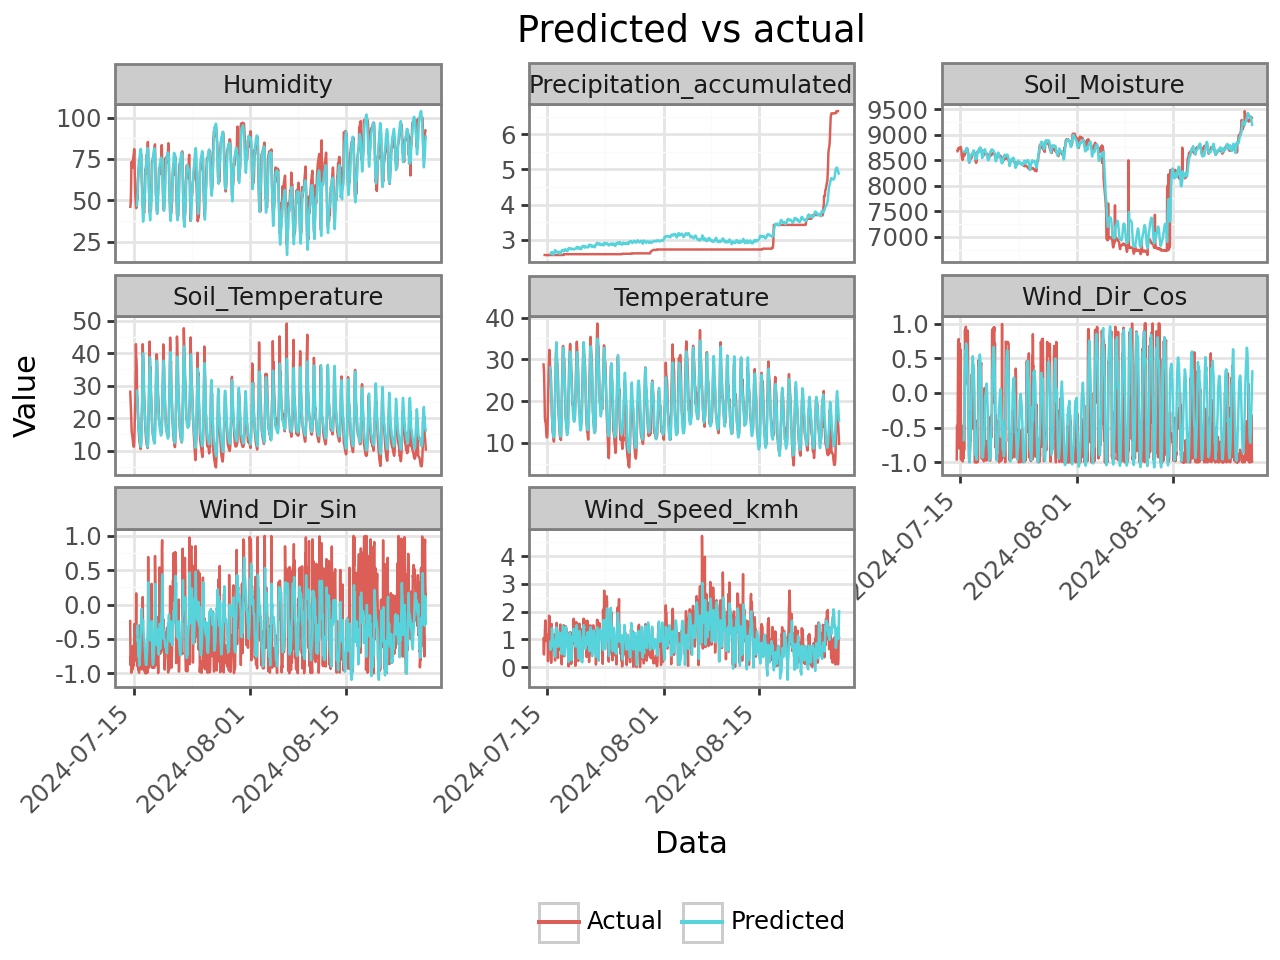

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [16]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

Predicting: |          | 0/? [00:00<?, ?it/s]

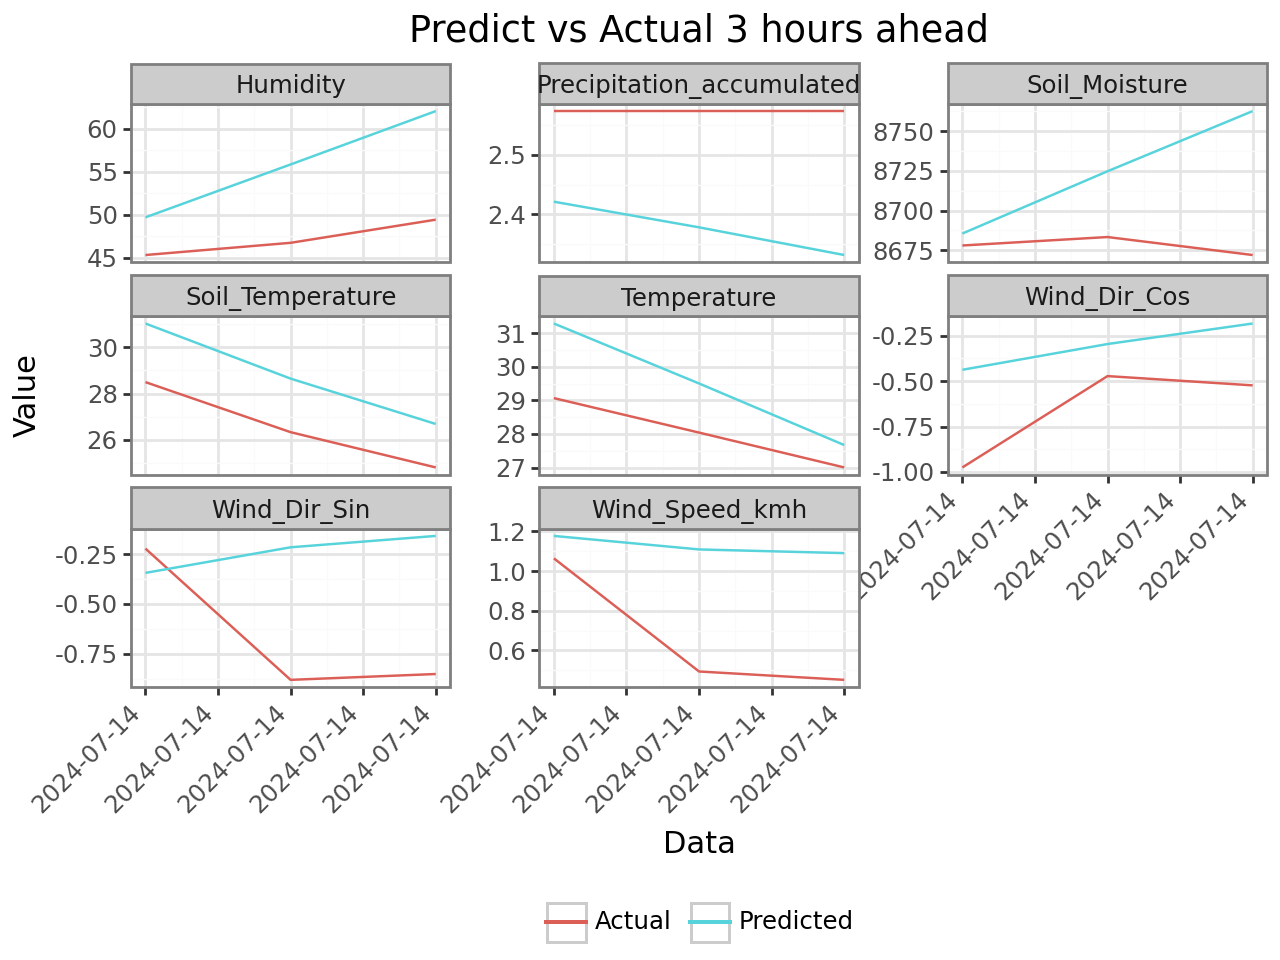

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(2.505103394452857), 'RMSE': np.float64(1.5827518423470108), 'MAE': np.float64(1.4499084678477452), 'R2': np.float64(-2.5290550374781344), 'SMAPE': np.float64(4.959999359386016)}, 'Precipitation_accumulated': {'MSE': np.float64(0.039415819470053626), 'RMSE': np.float64(0.1985341770830746), 'MAE': np.float64(0.19517960604082227), 'R2': np.float64(-inf), 'SMAPE': np.float64(7.897238592577619)}, 'Humidity': {'MSE': np.float64(87.49364680016096), 'RMSE': np.float64(9.353803867954522), 'MAE': np.float64(8.720344562093494), 'R2': np.float64(-29.016999287377875), 'SMAPE': np.float64(16.573194803142275)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.2658697095833282), 'RMSE': np.float64(0.5156255517168715), 'MAE': np.float64(0.45522475248757227), 'R2': np.float64(-2.41670292048857), 'SMAPE': np.float64(56.50603187670831)}, 'Soil_Moisture': {'MSE': np.float64(3331.4925070813547), 'RMSE': np.float64(57.719082694385875), 'MAE': np.float64(46.5445022911293), 'R2': np.fl

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

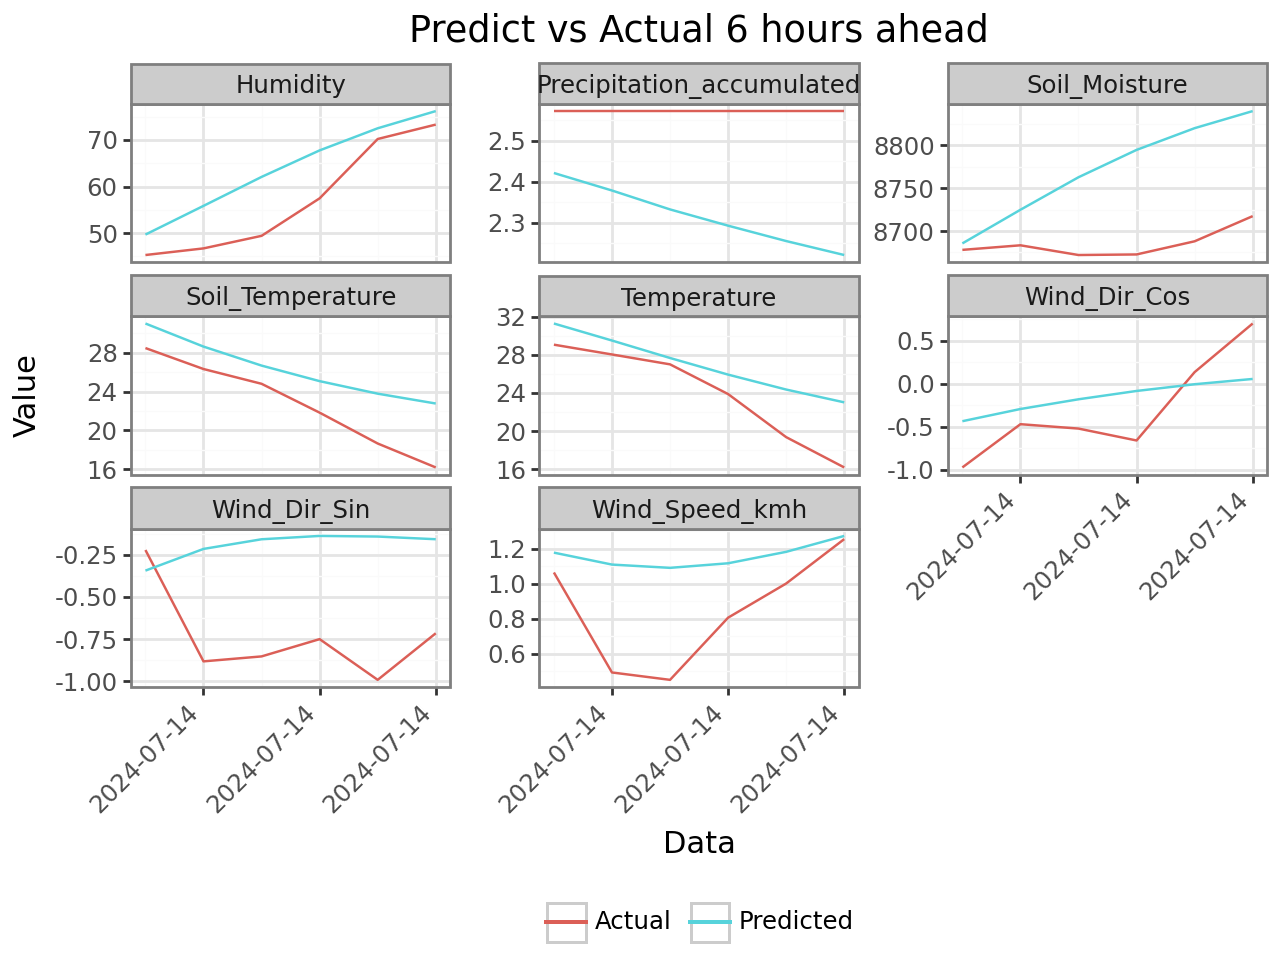

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(13.871223315904949), 'RMSE': np.float64(3.7244091230562937), 'MAE': np.float64(3.0350644075558786), 'R2': np.float64(0.3764709974912861), 'SMAPE': np.float64(13.456250871338556)}, 'Precipitation_accumulated': {'MSE': np.float64(0.07019259778763721), 'RMSE': np.float64(0.2649388566964786), 'MAE': np.float64(0.2557920860812685), 'R2': np.float64(-3.55918754868308e+29), 'SMAPE': np.float64(10.505003803229693)}, 'Humidity': {'MSE': np.float64(63.666072321390935), 'RMSE': np.float64(7.979102225275155), 'MAE': np.float64(6.940820946811392), 'R2': np.float64(0.48372461141149303), 'SMAPE': np.float64(12.207978472705529)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.15442528046665377), 'RMSE': np.float64(0.3929698213179401), 'MAE': np.float64(0.3123804466550527), 'R2': np.float64(-0.788084554881431), 'SMAPE': np.float64(36.6239940858266)}, 'Soil_Moisture': {'MSE': np.float64(9539.949842892403), 'RMSE': np.float64(97.6726668157085), 'MAE': np.float64(85.976665290403

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

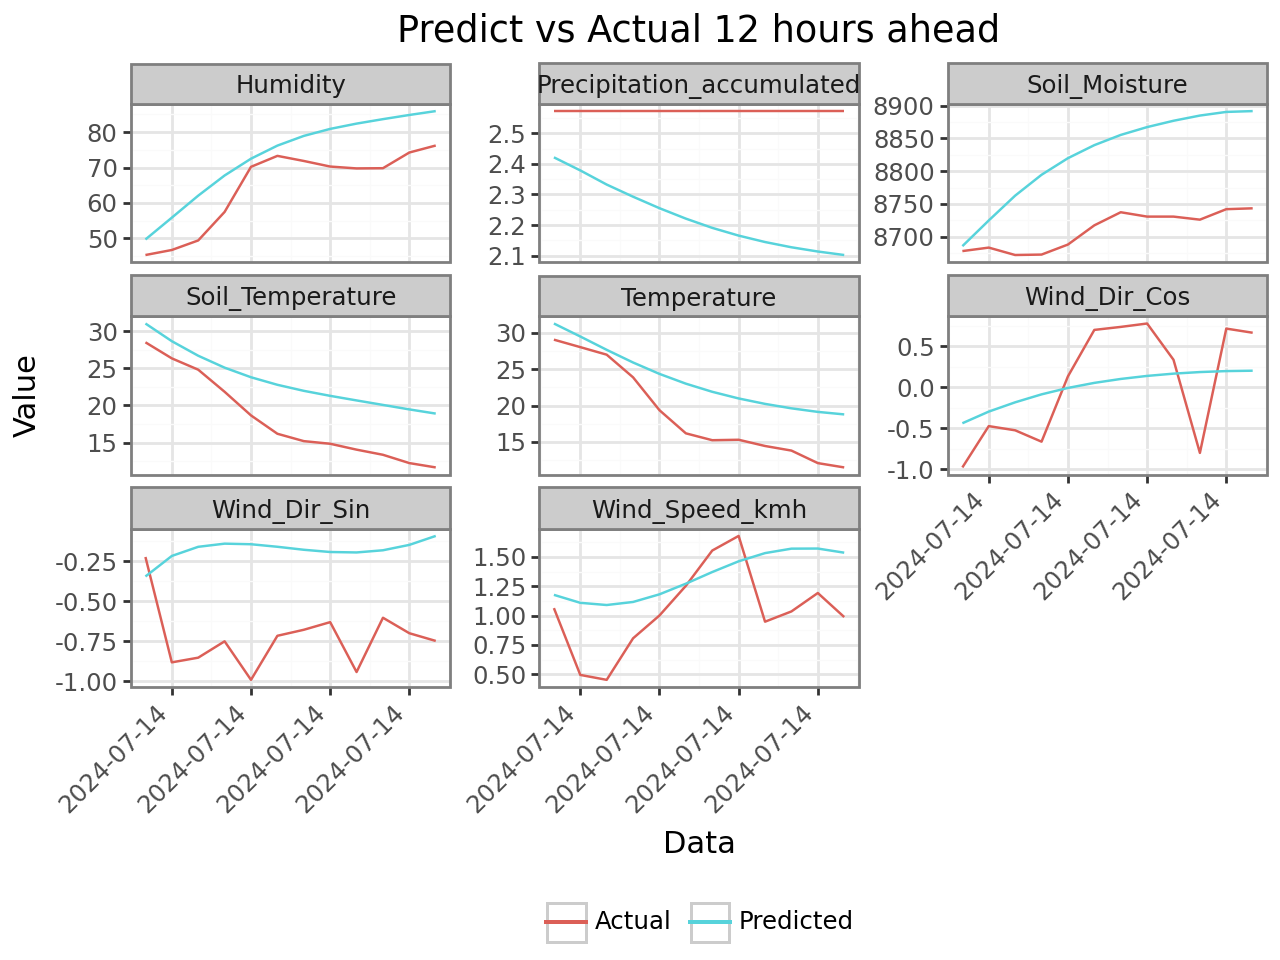

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(27.47781236740127), 'RMSE': np.float64(5.241928306205768), 'MAE': np.float64(4.7060250220993), 'R2': np.float64(0.27999297964818926), 'SMAPE': np.float64(25.766965752564357)}, 'Precipitation_accumulated': {'MSE': np.float64(0.1289031164448181), 'RMSE': np.float64(0.3590308015265795), 'MAE': np.float64(0.34393287061843036), 'R2': np.float64(-6.536164517302521e+29), 'SMAPE': np.float64(14.424515163494876)}, 'Humidity': {'MSE': np.float64(91.96975192307553), 'RMSE': np.float64(9.590086126989451), 'MAE': np.float64(8.847100215241065), 'R2': np.float64(0.23725068770096813), 'SMAPE': np.float64(13.056321426293792)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.1733445764962697), 'RMSE': np.float64(0.4163467022762036), 'MAE': np.float64(0.36013807133266384), 'R2': np.float64(-0.4307896748146025), 'SMAPE': np.float64(33.7647853521438)}, 'Soil_Moisture': {'MSE': np.float64(15055.59774311826), 'RMSE': np.float64(122.70125404052828), 'MAE': np.float64(114.413926554845

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

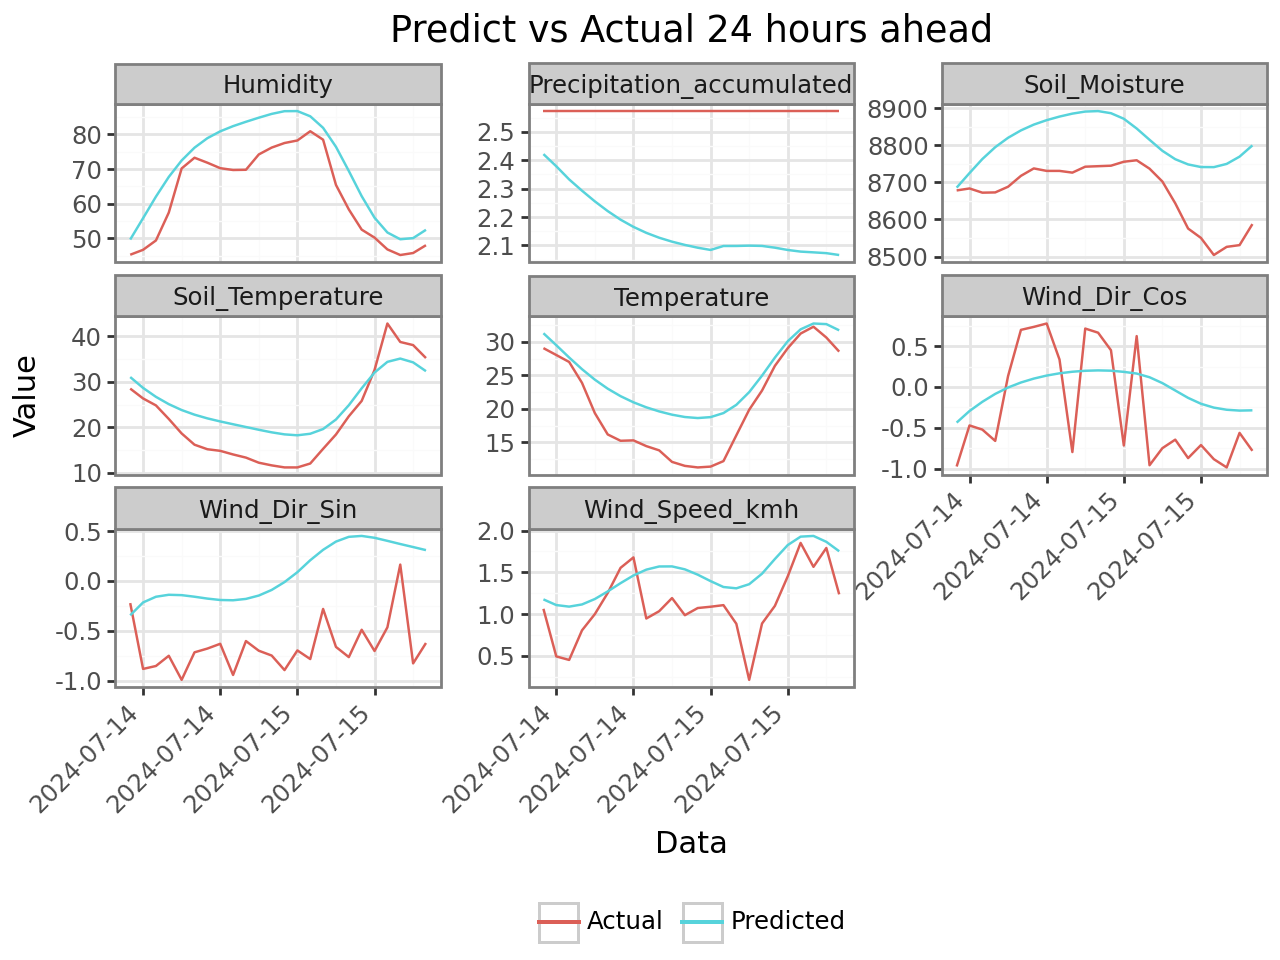

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(22.4875844399993), 'RMSE': np.float64(4.742107594730354), 'MAE': np.float64(4.014106852003244), 'R2': np.float64(0.5789795609184909), 'SMAPE': np.float64(21.987905545271516)}, 'Precipitation_accumulated': {'MSE': np.float64(0.18254692202150843), 'RMSE': np.float64(0.42725510180863663), 'MAE': np.float64(0.4149028131289904), 'R2': np.float64(-inf), 'SMAPE': np.float64(17.640842448465893)}, 'Humidity': {'MSE': np.float64(72.62608868112467), 'RMSE': np.float64(8.522094148806657), 'MAE': np.float64(7.801099652005848), 'R2': np.float64(0.5500644419809974), 'SMAPE': np.float64(11.890630797535133)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.21230635798399386), 'RMSE': np.float64(0.46076714073813235), 'MAE': np.float64(0.3908168004094896), 'R2': np.float64(-0.3488259660033821), 'SMAPE': np.float64(35.03096717341235)}, 'Soil_Moisture': {'MSE': np.float64(21776.388818290576), 'RMSE': np.float64(147.5682513899605), 'MAE': np.float64(136.24341779208302), 'R2': np.fl

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

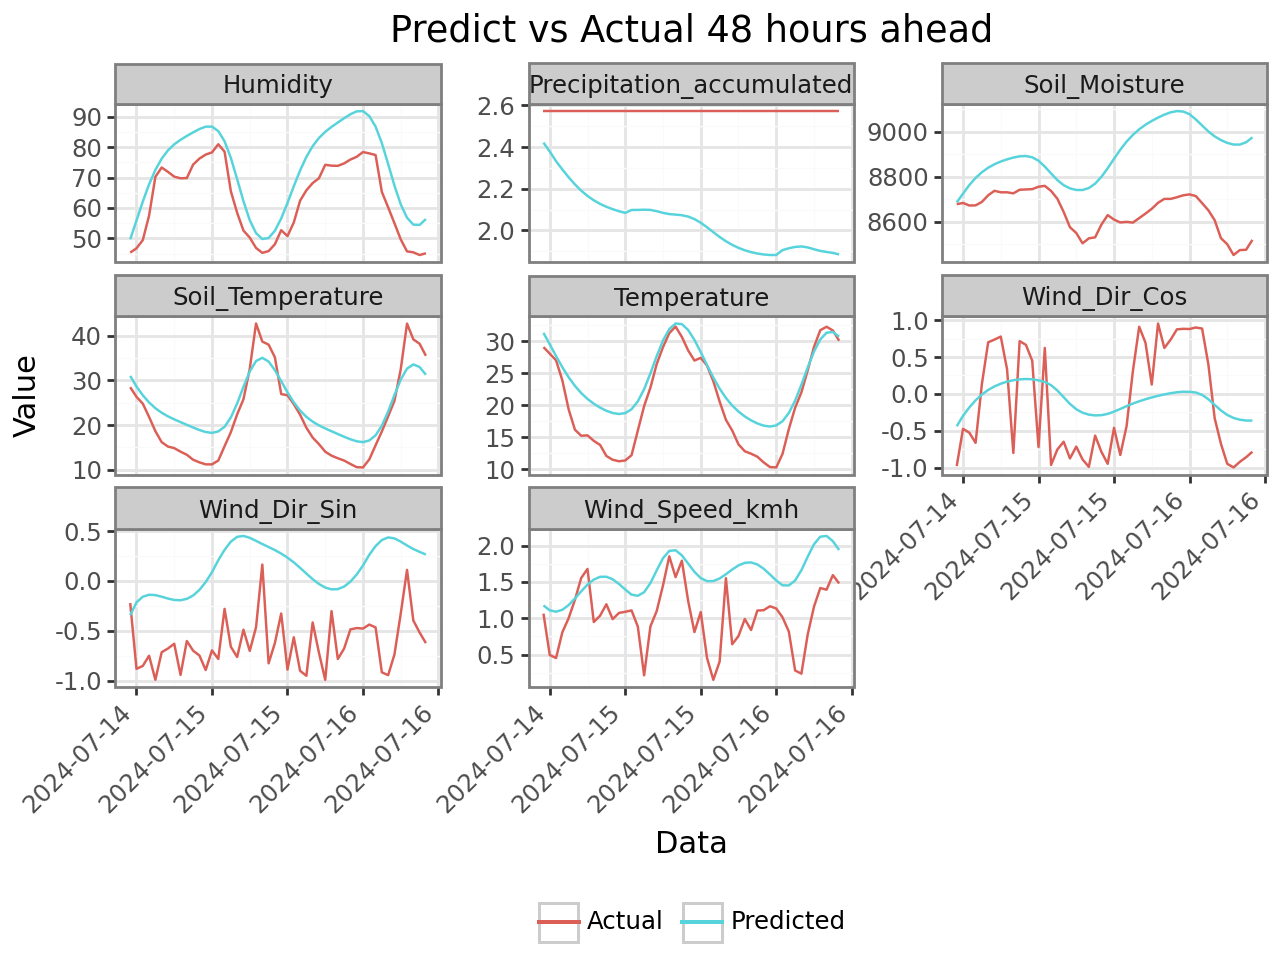

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(17.62518061603076), 'RMSE': np.float64(4.198235416937783), 'MAE': np.float64(3.4209083462913434), 'R2': np.float64(0.6795456479595428), 'SMAPE': np.float64(19.56335203559701)}, 'Precipitation_accumulated': {'MSE': np.float64(0.30035123379772827), 'RMSE': np.float64(0.5480430948362804), 'MAE': np.float64(0.5298581201875288), 'R2': np.float64(-1.522961687211918e+30), 'SMAPE': np.float64(23.161604128759006)}, 'Humidity': {'MSE': np.float64(110.54292926474481), 'RMSE': np.float64(10.513939759421527), 'MAE': np.float64(9.862142631408139), 'R2': np.float64(0.27542814847726527), 'SMAPE': np.float64(14.665931875099298)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.46555510246066073), 'RMSE': np.float64(0.6823159843215317), 'MAE': np.float64(0.5848174122819348), 'R2': np.float64(-1.7290126247601703), 'SMAPE': np.float64(50.55379673478001)}, 'Soil_Moisture': {'MSE': np.float64(85730.97093917093), 'RMSE': np.float64(292.79851594427686), 'MAE': np.float64(259.02933368

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

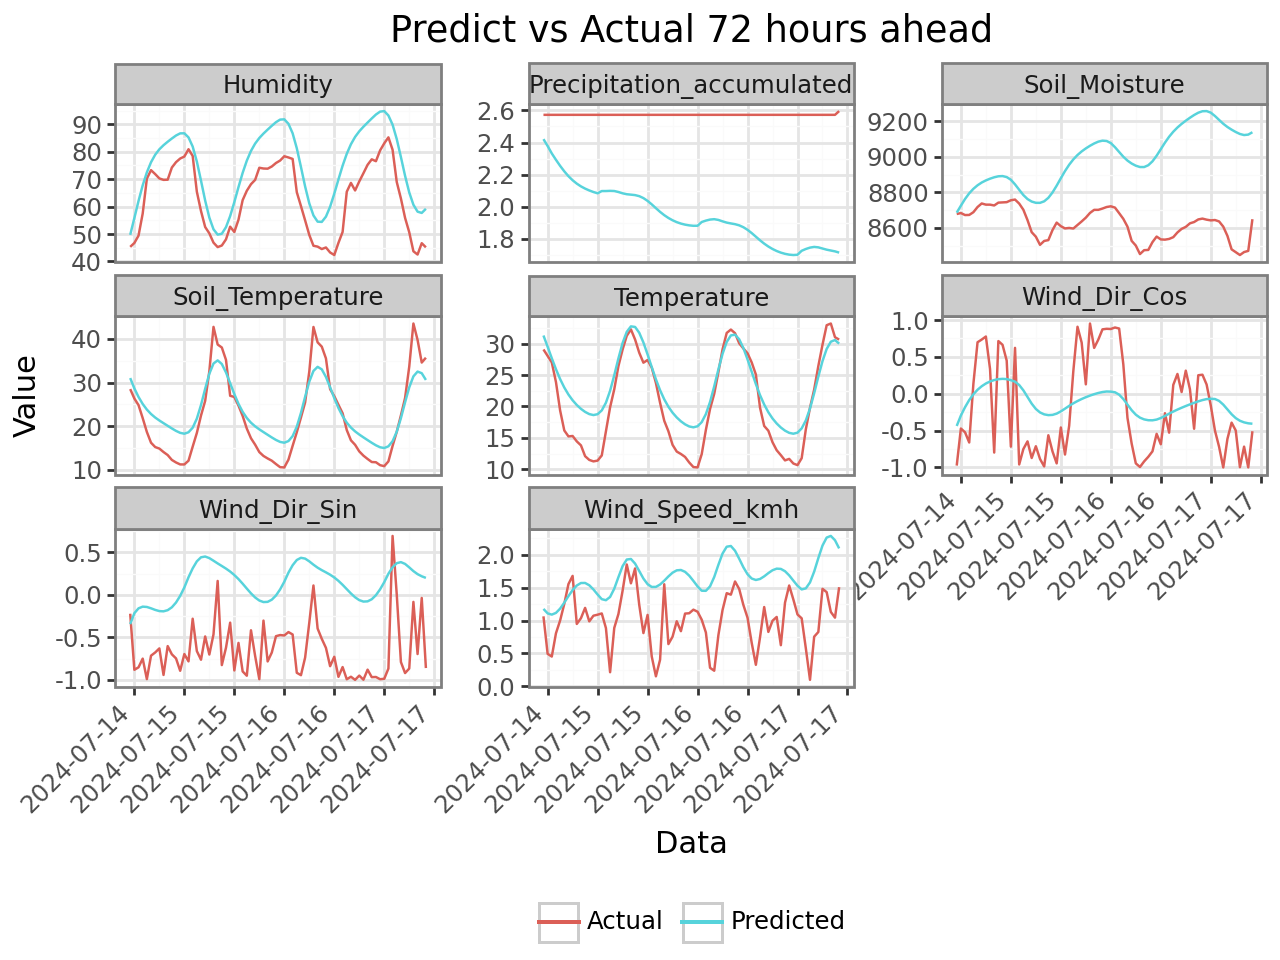

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(14.912010876944995), 'RMSE': np.float64(3.86160729191162), 'MAE': np.float64(3.1484218342694583), 'R2': np.float64(0.7401866764370857), 'SMAPE': np.float64(18.132517913552576)}, 'Precipitation_accumulated': {'MSE': np.float64(0.4263608141926424), 'RMSE': np.float64(0.652963103239871), 'MAE': np.float64(0.6273037519990922), 'R2': np.float64(-57423.0230828145), 'SMAPE': np.float64(28.124230437807416)}, 'Humidity': {'MSE': np.float64(161.222722161871), 'RMSE': np.float64(12.69735098994554), 'MAE': np.float64(11.823256913428937), 'R2': np.float64(0.06341660123451875), 'SMAPE': np.float64(17.67002196559382)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5582129930508657), 'RMSE': np.float64(0.7471365290566816), 'MAE': np.float64(0.6555006241072081), 'R2': np.float64(-2.5385151044936993), 'SMAPE': np.float64(54.42994093508599)}, 'Soil_Moisture': {'MSE': np.float64(176200.2292268376), 'RMSE': np.float64(419.7621102801414), 'MAE': np.float64(371.0628051200183), 'R2

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

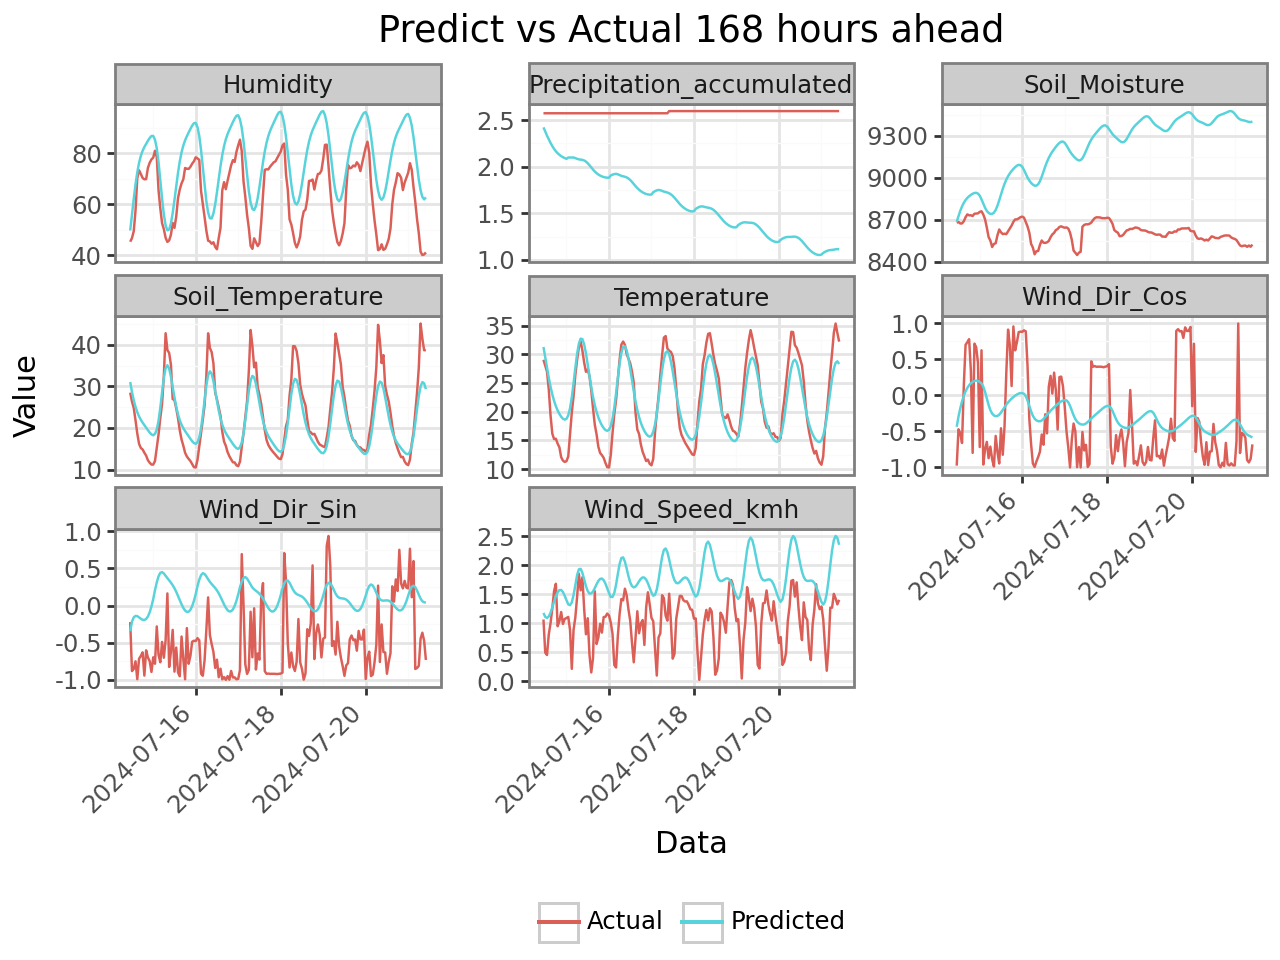

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(10.976071855923268), 'RMSE': np.float64(3.3130155230429073), 'MAE': np.float64(2.7276726076311775), 'R2': np.float64(0.7992054160996583), 'SMAPE': np.float64(14.067856988022408)}, 'Precipitation_accumulated': {'MSE': np.float64(1.1034893556791399), 'RMSE': np.float64(1.050471016106175), 'MAE': np.float64(0.9868570683715016), 'R2': np.float64(-8340.925699004209), 'SMAPE': np.float64(48.860678510468645)}, 'Humidity': {'MSE': np.float64(254.65455577119496), 'RMSE': np.float64(15.957899478665572), 'MAE': np.float64(14.994872034505729), 'R2': np.float64(-0.4291916510216547), 'SMAPE': np.float64(22.107742092051446)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.7159531256687929), 'RMSE': np.float64(0.8461401335882803), 'MAE': np.float64(0.740571958445206), 'R2': np.float64(-3.1235373679187957), 'SMAPE': np.float64(58.4743064568522)}, 'Soil_Moisture': {'MSE': np.float64(420652.39001431246), 'RMSE': np.float64(648.577204359136), 'MAE': np.float64(599.4085517722245)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

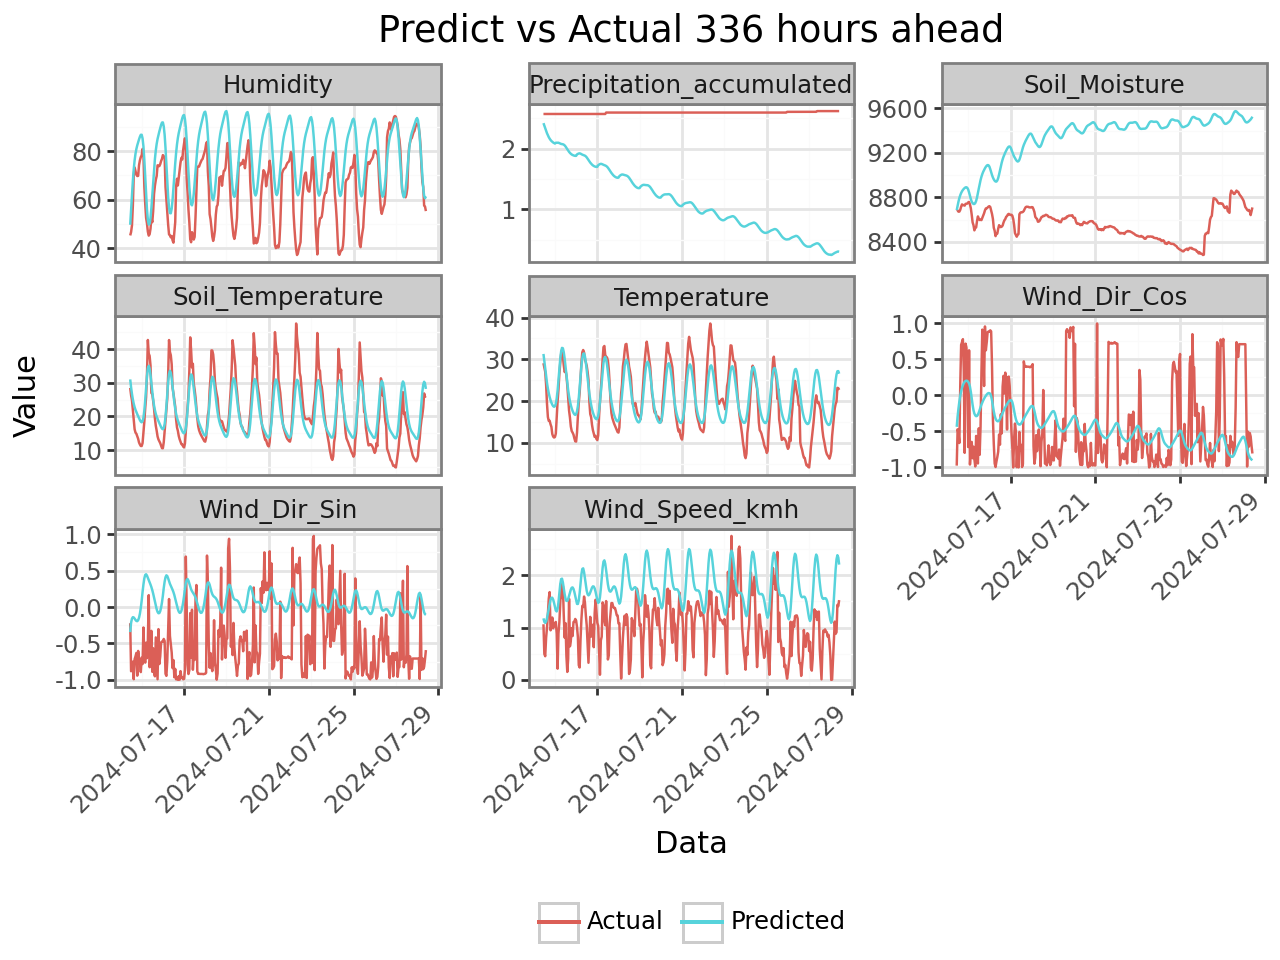

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(20.93440670529798), 'RMSE': np.float64(4.575413282458534), 'MAE': np.float64(3.804562723540043), 'R2': np.float64(0.6734444860500453), 'SMAPE': np.float64(22.499244299033723)}, 'Precipitation_accumulated': {'MSE': np.float64(2.4742727339754786), 'RMSE': np.float64(1.5729821149572802), 'MAE': np.float64(1.4666006388021602), 'R2': np.float64(-14338.841697226628), 'SMAPE': np.float64(84.96177966811085)}, 'Humidity': {'MSE': np.float64(254.83817499797374), 'RMSE': np.float64(15.963651681177891), 'MAE': np.float64(14.239188091482177), 'R2': np.float64(-0.21287314797994905), 'SMAPE': np.float64(21.073838762003273)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.728391968690377), 'RMSE': np.float64(0.8534588265935136), 'MAE': np.float64(0.7553975201329738), 'R2': np.float64(-1.8802619303428427), 'SMAPE': np.float64(62.19452079442107)}, 'Soil_Moisture': {'MSE': np.float64(678931.9376548914), 'RMSE': np.float64(823.9732627063158), 'MAE': np.float64(778.172314237413),

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

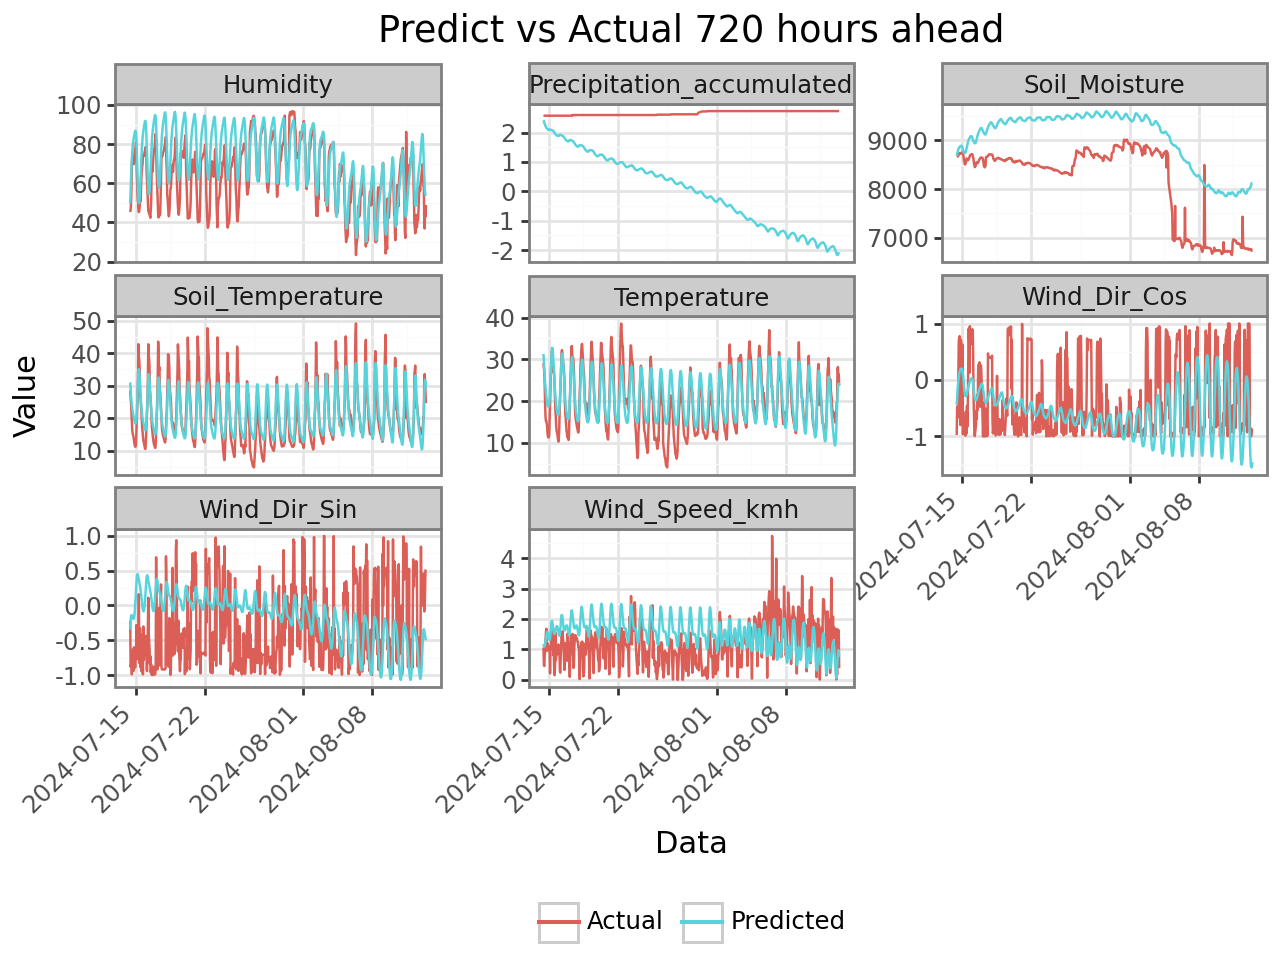

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(13.642154420064474), 'RMSE': np.float64(3.69352872197638), 'MAE': np.float64(2.971876881992025), 'R2': np.float64(0.7295263374969119), 'SMAPE': np.float64(16.988829704987065)}, 'Precipitation_accumulated': {'MSE': np.float64(8.7901735295879), 'RMSE': np.float64(2.9648226809689477), 'MAE': np.float64(2.66734225226459), 'R2': np.float64(-1987.5806101363848), 'SMAPE': np.float64(145.42838374062583)}, 'Humidity': {'MSE': np.float64(155.64272224565045), 'RMSE': np.float64(12.475685241526833), 'MAE': np.float64(10.105029181533332), 'R2': np.float64(0.41895527285606604), 'SMAPE': np.float64(15.826534774355352)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.7092354236402942), 'RMSE': np.float64(0.8421611625100591), 'MAE': np.float64(0.7061726537918049), 'R2': np.float64(-0.5914896355246193), 'SMAPE': np.float64(59.28150655388967)}, 'Soil_Moisture': {'MSE': np.float64(954052.9186796651), 'RMSE': np.float64(976.75632512908), 'MAE': np.float64(902.9085354135681), 'R2'

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

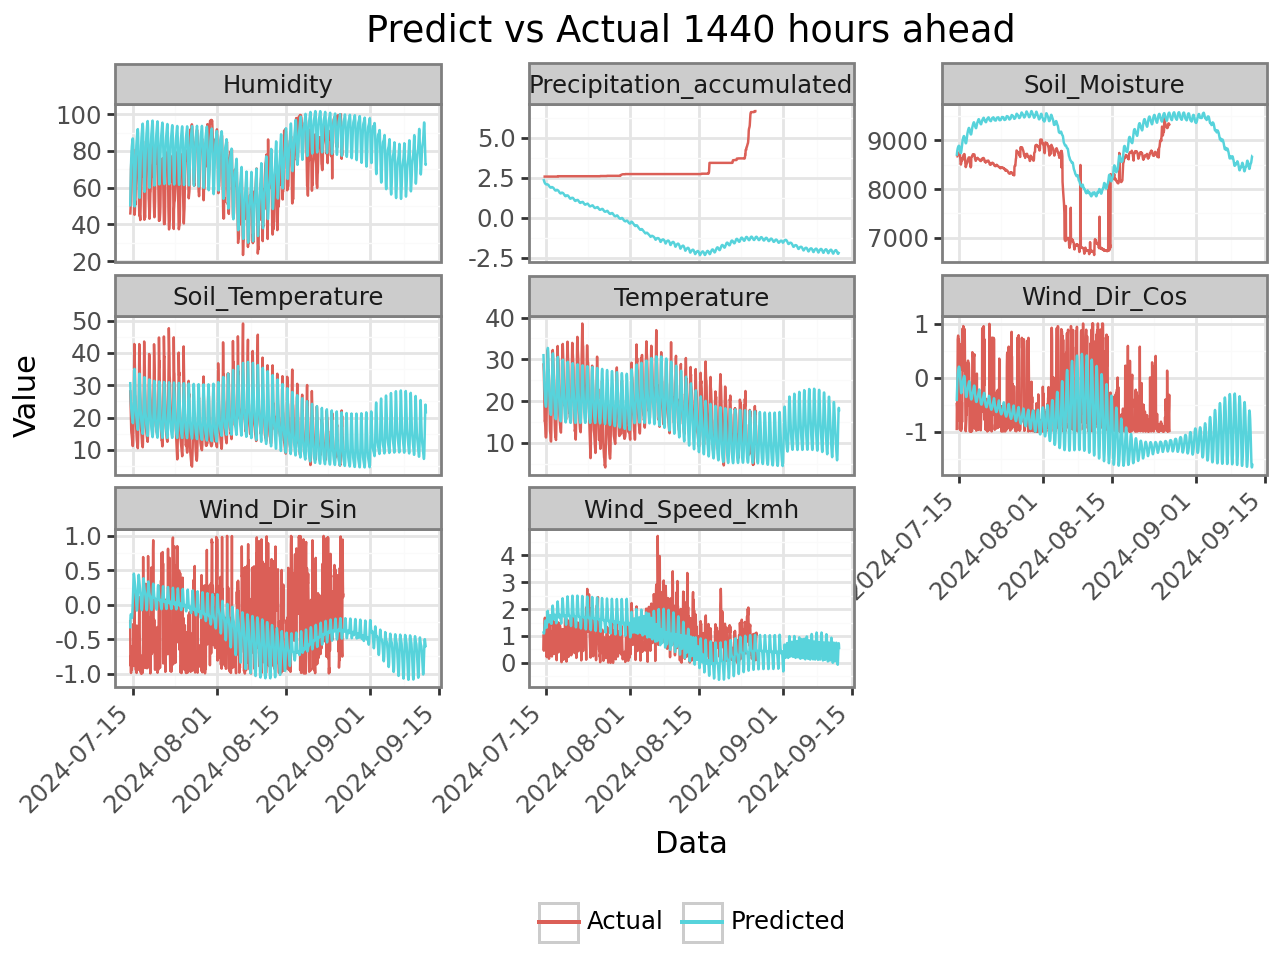

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/GRU/predict_1440.png


{'Temperature': {'MSE': np.float64(14.178942929430642), 'RMSE': np.float64(3.765493716557052), 'MAE': np.float64(3.0743039121885696), 'R2': np.float64(0.7181120589497039), 'SMAPE': np.float64(19.886986801281974)}, 'Precipitation_accumulated': {'MSE': np.float64(15.421886145522684), 'RMSE': np.float64(3.927070937164579), 'MAE': np.float64(3.51819113621575), 'R2': np.float64(-23.973691400231033), 'SMAPE': np.float64(162.14685577384452)}, 'Humidity': {'MSE': np.float64(139.7712082967944), 'RMSE': np.float64(11.822487398884991), 'MAE': np.float64(9.501472087653783), 'R2': np.float64(0.5501671029055375), 'SMAPE': np.float64(14.08868677841745)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.7022258316009), 'RMSE': np.float64(0.8379891595962922), 'MAE': np.float64(0.700753706389756), 'R2': np.float64(-0.6868662633868567), 'SMAPE': np.float64(78.21346316287884)}, 'Soil_Moisture': {'MSE': np.float64(768990.4817759856), 'RMSE': np.float64(876.9210236822844), 'MAE': np.float64(775.5832901397131), 'R2': 

In [8]:
m = "GRU"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [9]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)
